In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

/Users/atreish/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**I. Upload Data**

In [2]:
data = pd.read_excel('sunspots2.xlsx')
data.head(5)

,Sunspots,Month
0,9.4,1900-01-01
1,13.6,1900-02-01
2,8.6,1900-03-01
3,16.0,1900-04-01
4,15.2,1900-05-01


In [3]:
col = data.copy()
col1 = col.set_index('Month')

**II. Visualize Data**

/Users/atreish/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/atreish/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/atreish/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


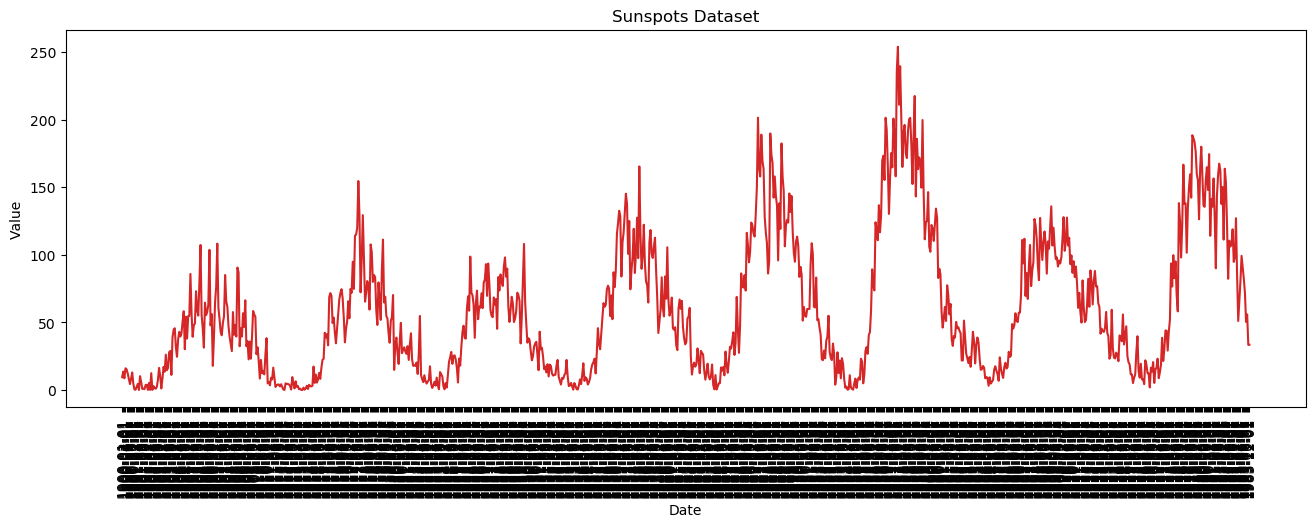

In [4]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.xticks(rotation=90)
    plt.show()

plot_df(data, x=data.Month, y=data.Sunspots, title='Sunspots Dataset')    

**III. Trend**

A periodic trend clearly exists here. There are months of spike and of decline throughout our entire timeline

**IV. Decomposition of Data**

In [5]:
data1 = data.copy()
data1['Month'] = pd.to_datetime(data1['Month'])
data1 = data1.set_index(data1['Month'])

In [6]:
'''If we have any that are less than or equal to zero we must address this because Multiplicative seasonality 
is not appropriate for zero and negative values. Here we see there are indeed several observations with 0 for the 
Sunspots column'''
data1[data1.Sunspots <= 0]

,Sunspots,Month
Month,,
1901-04-01,0.0,1901-04-01
1901-12-01,0.0,1901-12-01
1902-02-01,0.0,1902-02-01
1902-04-01,0.0,1902-04-01
1912-02-01,0.0,1912-02-01
1913-05-01,0.0,1913-05-01
1913-06-01,0.0,1913-06-01


In [7]:
#Add one to all values in the column
data1['Sunspots'] += 1
data1['Sunspots'].head(5)

Month
1900-01-01    10.4
1900-02-01    14.6
1900-03-01     9.6
1900-04-01    17.0
1900-05-01    16.2
Name: Sunspots, dtype: float64

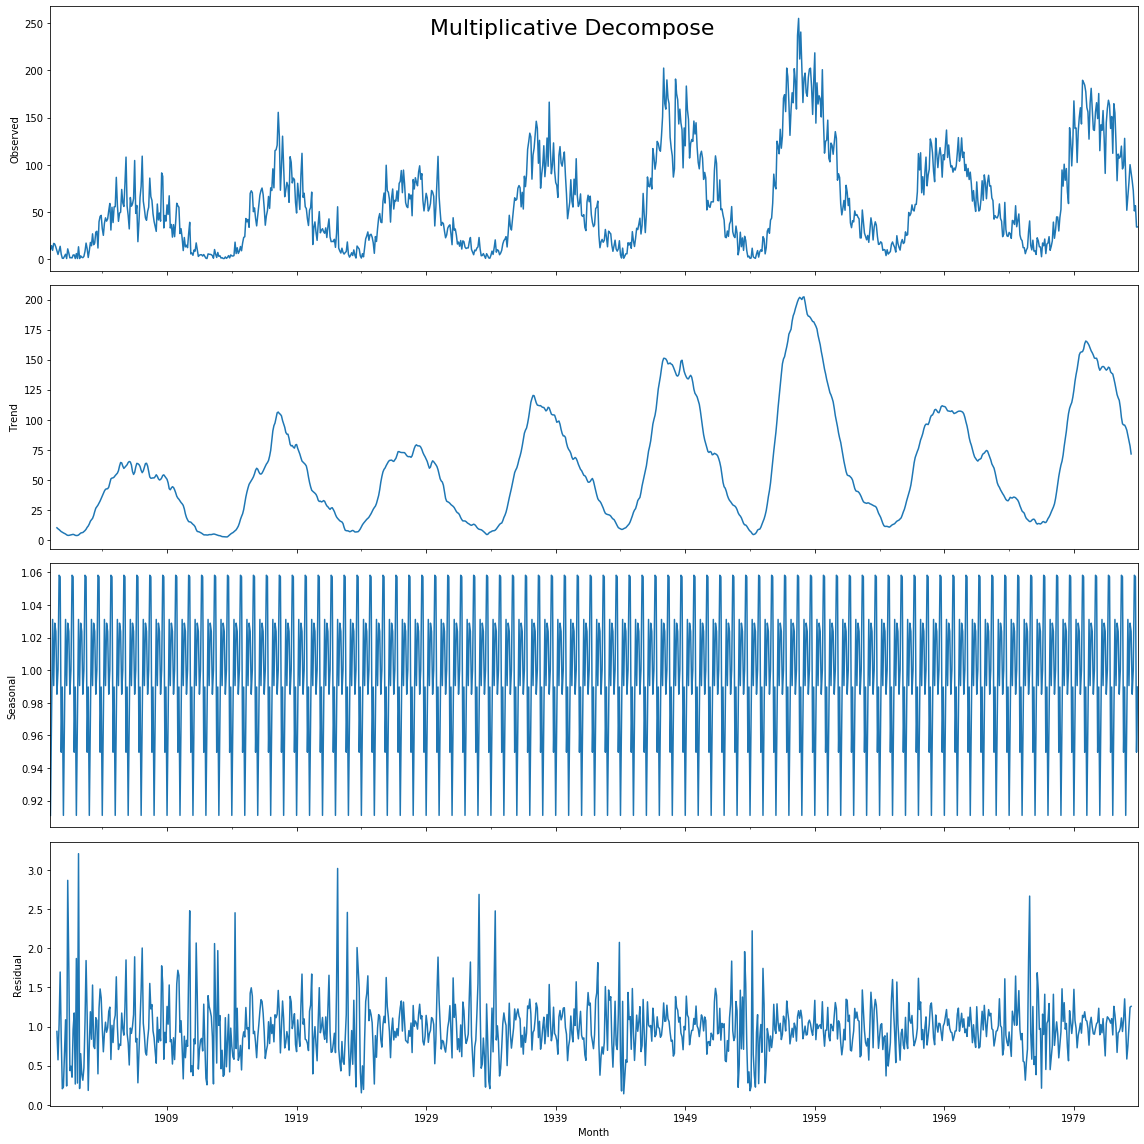

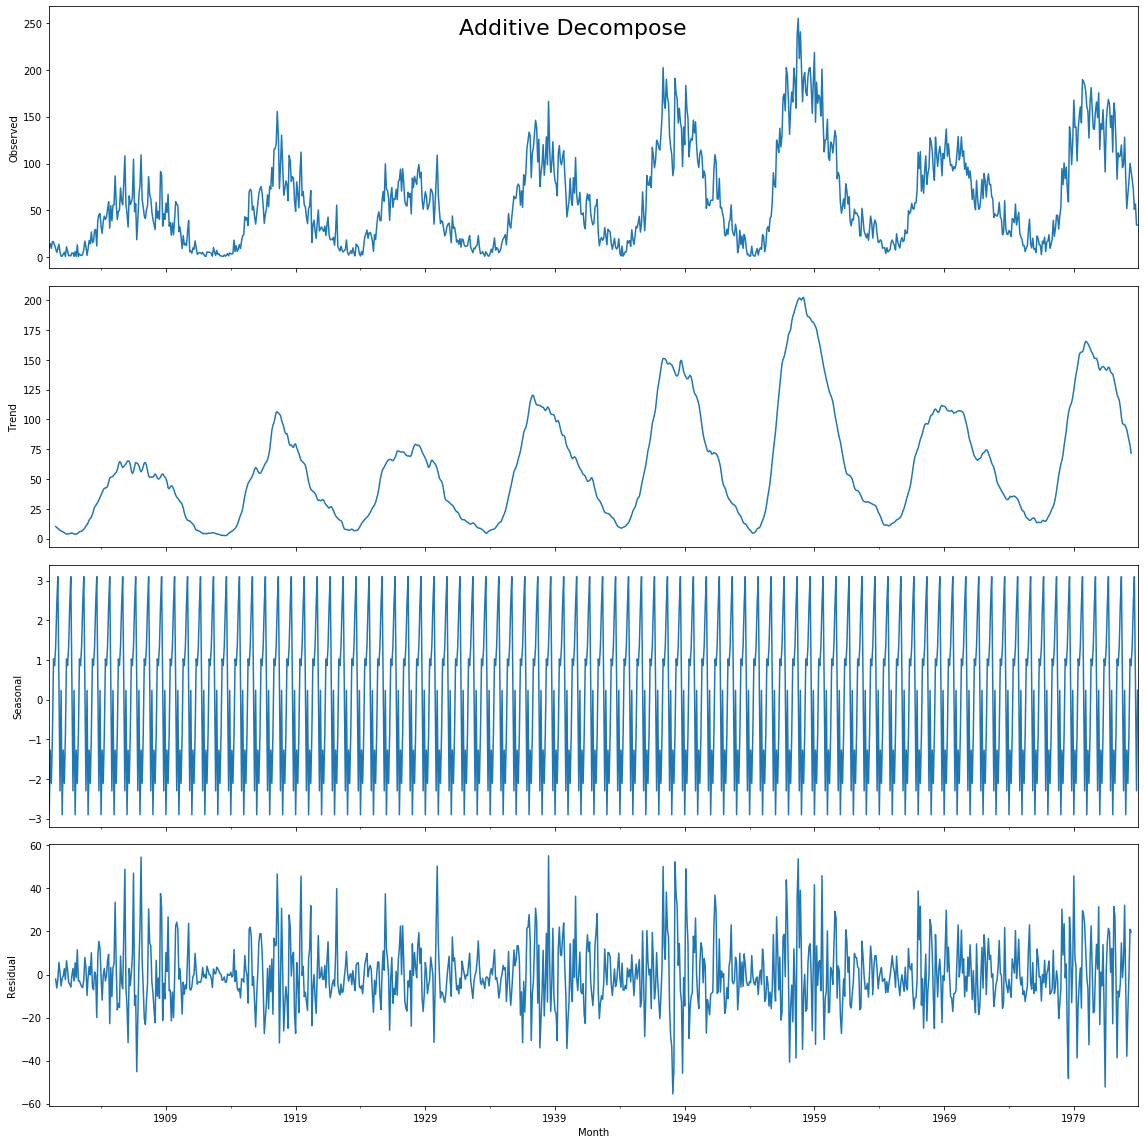

In [8]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(data1['Sunspots'], model='multiplicative')

# Additive Decomposition
result_add = seasonal_decompose(data1['Sunspots'], model='additive')

# Plot
plt.rcParams.update({'figure.figsize': (16,16)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

**V. Test for Stationarity**

In [9]:
'''To thest for Stationarity we will use the ADF Test'''

result = adfuller(data1.Sunspots, autolag='AIC')
print(f'\nADF Statistic: {result[0]}')
print(f'\np-value: {result[1]}')
for key, value in result[4].items():
    print('\nCritial Values:')
    print(f'   {key}, {value}')


ADF Statistic: -5.657955854164503

p-value: 9.524461009602806e-07

Critial Values:
   1%, -3.4369860032923145

Critial Values:
   5%, -2.8644697838498376

Critial Values:
   10%, -2.5683299626694422


p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

**VI. Detrend the Time Series**

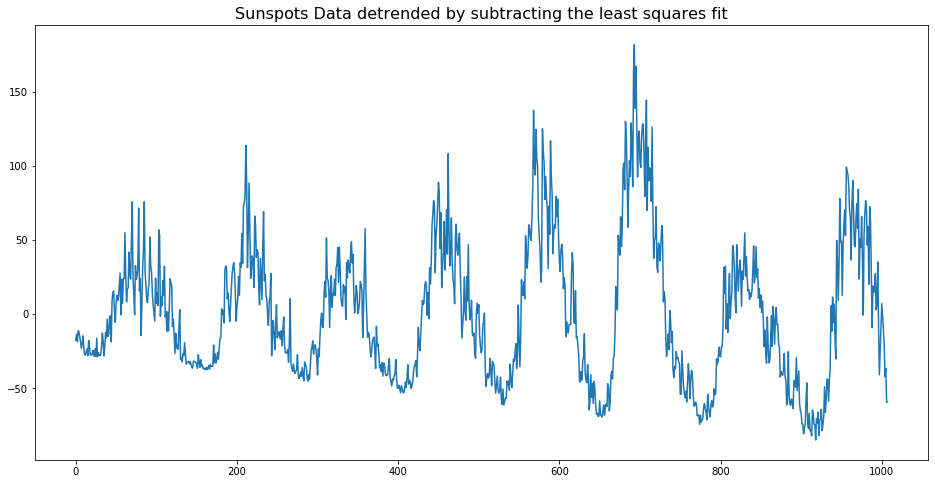

In [10]:
detrended = signal.detrend(data.Sunspots.values)
plt.figure(figsize=(16,8))
plt.plot(detrended)
plt.title('Sunspots Data detrended by subtracting the least squares fit', fontsize=16)
plt.show()

**VII. Deseasonalize**

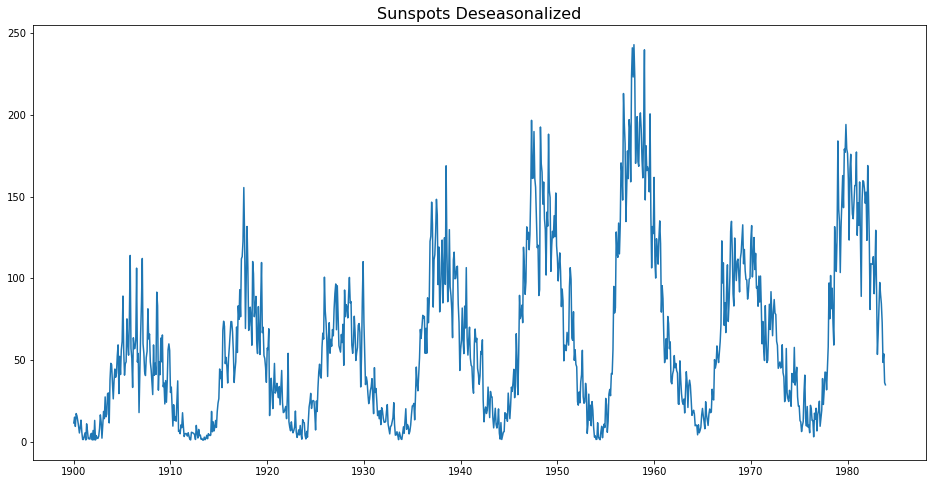

In [11]:
deseasonalized = data1.Sunspots.values / result_mul.seasonal
plt.figure(figsize=(16,8))
plt.plot(deseasonalized)
plt.title('Sunspots Deseasonalized', fontsize=16)
plt.show()

# ARIMA MODEL

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1007
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -4274.998
Method:                       css-mle   S.D. of innovations             16.882
Date:                Sun, 07 Nov 2021   AIC                           8563.997
Time:                        00:42:08   BIC                           8598.400
Sample:                             1   HQIC                          8577.068
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0292      0.284      0.103      0.918      -0.528       0.586
ar.L1.D.y     -0.3473      0.031    -11.029      0.000      -0.409      -0.286
ar.L2.D.y     -0.2701      0.033     -8.104      0.0

<Figure size 1080x576 with 0 Axes>

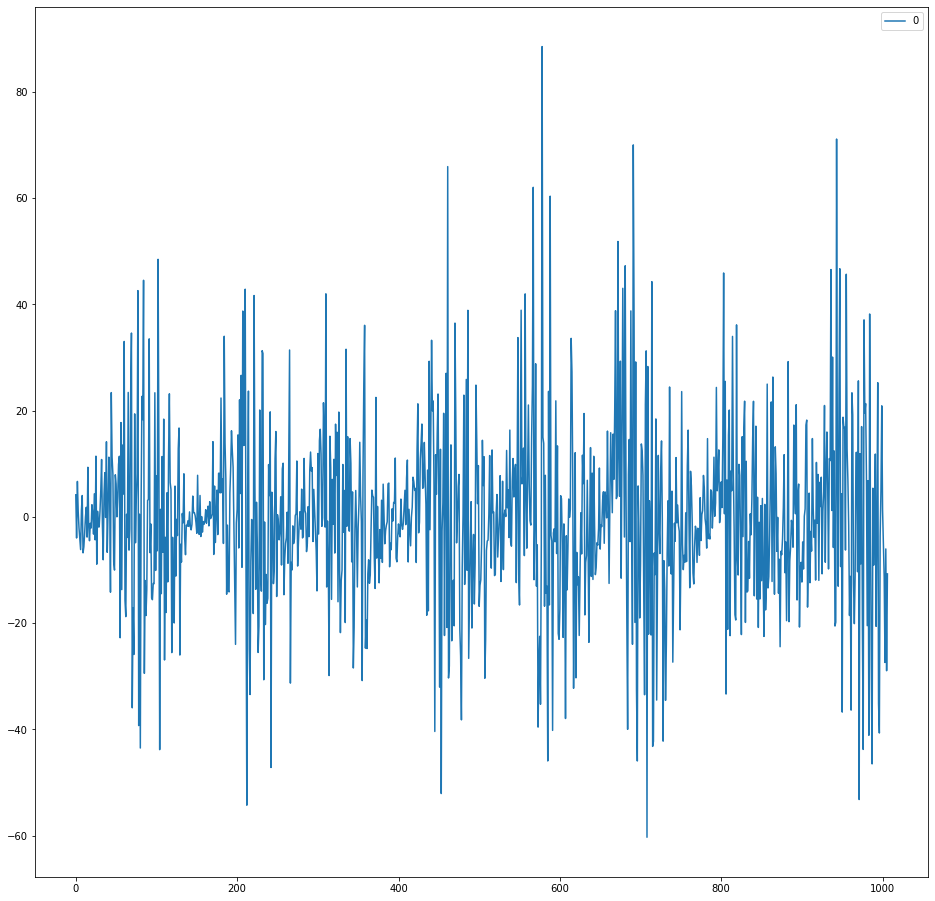

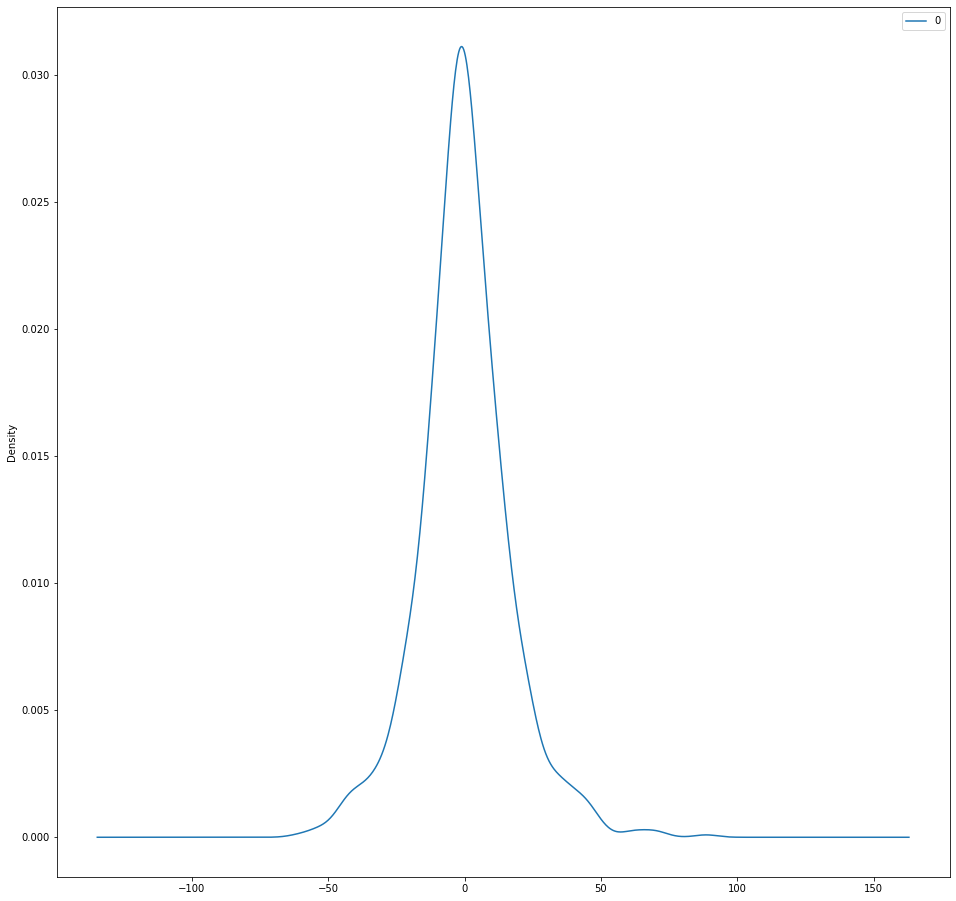

                 0
count  1007.000000
mean      0.002114
std      16.890167
min     -60.290113
25%      -8.864463
50%      -0.806079
75%       8.175455
max      88.536212


In [12]:
model = ARIMA(np.asarray(data1['Sunspots']), order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)

plt.figure(figsize=(15,8))
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

**ARIMA Forecasting**

In [13]:
len(data1['Sunspots'])

1008

predicted=30.714657, expected=60.300000
predicted=51.785840, expected=31.700000
predicted=33.463827, expected=24.900000
predicted=30.455609, expected=24.300000
predicted=28.421298, expected=28.600000
predicted=28.298254, expected=27.000000
predicted=28.440530, expected=22.300000
predicted=24.086724, expected=41.300000
predicted=36.131447, expected=40.500000
predicted=36.427049, expected=37.000000
predicted=35.993396, expected=56.800000
predicted=50.303518, expected=34.600000
predicted=36.627168, expected=41.200000
predicted=42.144316, expected=48.100000
predicted=46.335174, expected=26.000000
predicted=31.176210, expected=21.500000
predicted=28.599504, expected=19.900000
predicted=24.104164, expected=12.500000
predicted=17.084794, expected=12.500000
predicted=16.066724, expected=6.100000
predicted=9.653797, expected=10.000000
predicted=10.856745, expected=12.400000
predicted=11.862188, expected=29.200000
predicted=22.714770, expected=40.700000
predicted=32.244409, expected=14.900000
pr

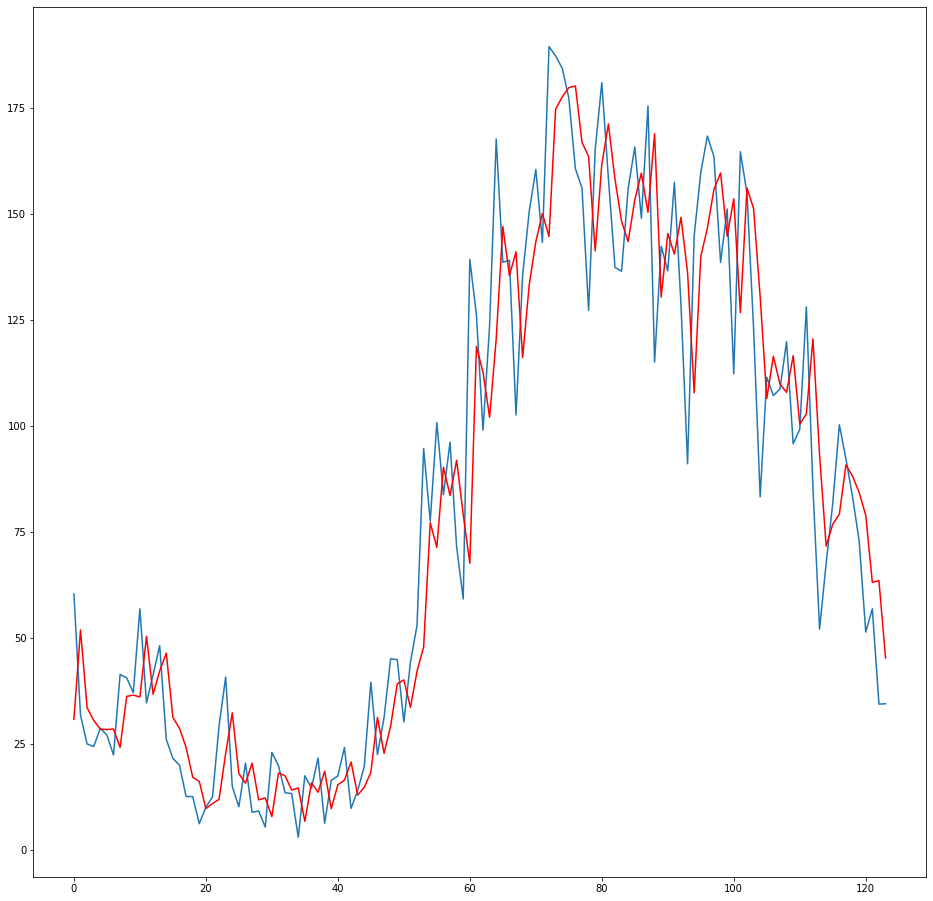

In [14]:
X = data1['Sunspots'].values

train, test = X[0:884], X[884:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
    
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()